### Multiclass Classification with Hybrid Quantum-Classical DenseNet in FastQML

This notebook showcases the utilization of FastQML for running hybrid quantum-classical models. In this notebook we will use [DenseNet](https://arxiv.org/abs/1608.06993) model  to evaluate it on popular CIFAR10 dataset first in classical form and then quantum-classical hybrid form . **This notebook does not aim to achieve the best possible results either on classical nor hybrid setup. The goal is only to show FastQML functionalities**. 

In FastQML all quantum components are implemented with Pennylane due to its flexibility. For the classical deep learning components, we use [FLAX](https://flax.readthedocs.io/en/latest/) - a framework developed by Google and compatible with JAX, which serves as the computational backend for all operations in FastQML.

JAX is designed to automatically select the most suitable computing platform, prioritizing GPU/TPU if available, and defaulting to CPU otherwise. More information on JAX's supported platforms can be found here: [JAX Installation Guide](https://jax.readthedocs.io/en/latest/installation.html). The experiments presented in this notebook were carried out on a system equipped with a 13th Gen Intel Core-i9 processor and an Nvidia GeForce RTX 4080 Laptop GPU with 12 GB of memory.

Let's begin by verifying the availability of a GPU backend for JAX.


In [1]:
import jax

if jax.default_backend() == 'gpu':
    device = jax.devices()[0]
    if device.platform == 'gpu':
        print(f"Device set to GPU with visible device {[device]}")
    else:
        print(f"No visible GPU device found, falling back to CPU")
else:
    print("CPU is set as the default JAX backend")

Device set to GPU with visible device [cuda(id=0)]


With the backend device identified, we can proceed to set up our environment by importing necessary libraries and defining project constants. For this project, the CIFAR10 dataset will be sourced from the torchvision library, allowing us to leverage PyTorch's data processing capabilities which are fully compatible with FastQML models.

In [2]:
# JAX imports
import optax
import flax.linen as nn
from jax import numpy as jnp

# Pytorch imports
import torch
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

# Helper imports for evaluation
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# FastQML imports
from fast_qml.quantum_circuits.feature_maps import IQPEmbedding
from fast_qml.quantum_circuits.variational_forms import EfficientSU2
from fast_qml.estimators.qnn import QNNClassifier
from fast_qml.estimators.hybrid_qnn import HybridClassifier
from fast_qml.estimators.classical import ClassicalClassifier

To maintain clarity and organization throughout the project, let's consolidate all the constants we'll be using into one place. For demonstration purposes, we will limit the training of both the classical and hybrid models to just 75 epochs and train models only on 20% of the original dataset. This decision is made to showcase the process and functionality of the models within the FastQML framework, rather than aiming to achieve the highest possible performance outcomes.

In [15]:
# Project constants
DATASET_PATH = 'data'
MODEL_PATH = 'trained_models'
RANDOM_SEED = 42
IMAGE_DIMS = (32, 32, 3)
BATCH_SIZE = 512
C_LEARNING_RATE = 1e-3
H_LEARNING_RATE = 7.5e-3
NUM_EPOCHS = 75
TRAIN_SIZE = 10000
EVAL_SIZE = 2000
CLASSES_LABELS = (
    'airplane', 'automobile', 'bird', 'cat',  
    'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
)
NUM_CLASSES = len(CLASSES_LABELS)

To prepare our dataset for training, it's essential to define preprocessing transformations that normalize the raw data. Moreover, to mitigate the risk of over-fitting, we'll incorporate basic data augmentation techniques into our training regimen.

It's crucial to note the difference in dimension ordering between PyTorch and Flax. PyTorch uses the (Channels, Height, Width) format, while Flax operates with (Height, Width, Channels). To bridge this gap, we'll introduce a custom PermuteTransform transform, ensuring compatibility of the PyTorch dataset with our Flax-based model architecture. This step is vital for seamless data integration and processing within our hybrid quantum-classical framework.

In [4]:
# We need to extract data means and std for normalization
train_dataset = CIFAR10(
    root=DATASET_PATH, train=True, download=True)
DATA_MEANS = (train_dataset.data / 255.0).mean(axis=(0, 1, 2))
DATA_STD = (train_dataset.data / 255.0).std(axis=(0, 1, 2))

# PyTorch has different dimensions order than Flax, so we need to fix it
class PermuteTransform:
    """ Permute the tensor from (C, H, W) to (H, W, C) """
    def __call__(self, x):
        return x.permute(1, 2, 0)

# Preprocessing transforms
process_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(DATA_MEANS, DATA_STD),
    PermuteTransform()
])
    
# Additional augmentations for training dataset
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((32, 32),scale=(0.8, 1.0),ratio=(0.9, 1.1)),
    process_transform
])

Files already downloaded and verified


Next, we'll proceed with dataset creation and organize it into training, validation, and test sets. To ensure that data augmentations are applied exclusively to the training set, we'll employ a strategy where we load the training dataset twice, then divide it accordingly. This approach ensures that augmentations enhance the model's robustness without affecting the integrity of the validation set, facilitating an accurate evaluation of the model's performance.

In [5]:
# Create datasets for training, validation and test
train_dataset = CIFAR10(
    root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(
    root=DATASET_PATH, train=True, transform=process_transform, download=True)
test_set = CIFAR10(
    root=DATASET_PATH, train=False, transform=process_transform, download=True)

# Split the data into training and validation parts
generator = torch.Generator().manual_seed(RANDOM_SEED)
train_set, _ = torch.utils.data.random_split(
    train_dataset, [TRAIN_SIZE, 50000 - TRAIN_SIZE], generator=generator)
_, val_set = torch.utils.data.random_split(
    val_dataset, [50000 - EVAL_SIZE, EVAL_SIZE], generator=generator)

# Create dataloaders
train_loader = DataLoader(
    train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(
    val_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader = DataLoader(
    test_set, batch_size=EVAL_SIZE, shuffle=False, drop_last=False)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Next, we'll focus on constructing the DenseNet architecture by defining its components. Once the architecture is defined, we'll proceed to create a model instance, preparing it for training and evaluation on our dataset.

In [6]:
class DenseLayer(nn.Module):
    bn_size : int
    growth_rate : int
    batch_norm: bool

    @nn.compact
    def __call__(self, x, train=True):
        # First layer
        z = nn.BatchNorm(use_running_average=not train)(x) if self.batch_norm else x
        z = nn.relu(z)
        z = nn.Conv(
            self.bn_size * self.growth_rate,
            kernel_size=(1, 1),
            kernel_init=nn.initializers.he_normal(),
            use_bias=False)(z)
        
        #Second layer
        z = nn.BatchNorm(use_running_average=not train)(x) if self.batch_norm else z
        z = nn.relu(z)
        z = nn.Conv(
            self.growth_rate,
            kernel_size=(3, 3),
            kernel_init=nn.initializers.he_normal(),
            use_bias=False)(z)
  
        return jnp.concatenate([x, z], axis=-1)
    
class DenseBlock(nn.Module):
    num_layers : int 
    bn_size : int
    growth_rate : int
    batch_norm: bool

    @nn.compact
    def __call__(self, x, train=True):
        for _ in range(self.num_layers):
            x = DenseLayer(
                bn_size=self.bn_size,
                growth_rate=self.growth_rate,
                batch_norm=self.batch_norm
            )(x, train=train)
        return x
        
class TransitionLayer(nn.Module):
    c_out : int
    batch_norm: bool

    @nn.compact
    def __call__(self, x, train=True):
        x = nn.BatchNorm(use_running_average=not train)(x) if self.batch_norm else x
        x = nn.relu(x)
        x = nn.Conv(
            self.c_out,
            kernel_size=(1, 1),
            kernel_init=nn.initializers.he_normal(),
            use_bias=False)(x)
        return nn.avg_pool(x, (2, 2), strides=(2, 2))
    
class DenseNet(nn.Module):
    num_outputs : int
    num_layers : tuple
    bn_size : int
    growth_rate : int
    batch_norm: bool

    @nn.compact
    def __call__(self, x, train=True):
        c_hidden = self.growth_rate * self.bn_size 

        x = nn.Conv(
            c_hidden,
            kernel_size=(3, 3),
            kernel_init=nn.initializers.he_normal())(x)

        for block_idx, num_layers in enumerate(self.num_layers):
            x = DenseBlock(
                num_layers=num_layers,
                bn_size=self.bn_size,
                growth_rate=self.growth_rate,
                batch_norm=self.batch_norm)(x, train=train)
            c_hidden += num_layers * self.growth_rate
            
            if block_idx < len(self.num_layers) - 1:
                x = TransitionLayer(c_out=c_hidden // 2, batch_norm=self.batch_norm)(x, train=train)
                c_hidden //= 2
        
        x = nn.BatchNorm(use_running_average=not train)(x) if self.batch_norm else x
        x = nn.relu(x)
        x = x.mean(axis=(1, 2))
        x = nn.Dense(self.num_outputs)(x)
        
        return x
    
# Create a DenseNet model instance
c_model = DenseNet(
    num_outputs=NUM_CLASSES,
    num_layers=[3, 3, 3],
    bn_size=2,
    growth_rate=12,
    batch_norm=True
)

Now, it's time to define and train our classical estimator model using FastQML, which offers a straightforward and intuitive interface. With our model already defined, we simply need to specify the loss function, optimizer, and the number of classes in our dataset. Since our model incorporates batch normalization, it's crucial to enable the batch_norm setting. This adjustment is necessary for proper batch statistics handling within Flax's framework and the optimizer. Following these setups, we will execute the fit method on our estimator, passing in the dataset and the training parameters we've established. 

In [7]:
c_estimator = ClassicalClassifier(
    input_shape=IMAGE_DIMS,
    c_model=c_model,
    loss_fn=optax.softmax_cross_entropy_with_integer_labels,
    optimizer_fn=optax.adamw,
    batch_norm=True,
    classes_num=NUM_CLASSES
)

c_estimator.fit(
    train_data=train_loader,
    train_targets=None,
    val_data=val_loader,
    val_targets=None,
    learning_rate=C_LEARNING_RATE,
    num_epochs=NUM_EPOCHS
)

Epoch 1/75 - train_loss: 2.157615185 - val_loss: 2.297941923
Epoch 2/75 - train_loss: 1.903548360 - val_loss: 2.207359076
Epoch 3/75 - train_loss: 1.774349451 - val_loss: 2.117383957
Epoch 4/75 - train_loss: 1.670176268 - val_loss: 1.982799411
Epoch 5/75 - train_loss: 1.594126701 - val_loss: 1.975441694
Epoch 6/75 - train_loss: 1.527965665 - val_loss: 1.976442099
Epoch 7/75 - train_loss: 1.463677883 - val_loss: 1.790029407
Epoch 8/75 - train_loss: 1.410812616 - val_loss: 1.696713328
Epoch 9/75 - train_loss: 1.365477562 - val_loss: 1.733097315
Epoch 10/75 - train_loss: 1.328345776 - val_loss: 1.834279656
Epoch 11/75 - train_loss: 1.295344234 - val_loss: 1.699783802
Epoch 12/75 - train_loss: 1.266135931 - val_loss: 1.724008083
Epoch 13/75 - train_loss: 1.238911986 - val_loss: 1.558436275
Epoch 14/75 - train_loss: 1.206711292 - val_loss: 1.532627463
Epoch 15/75 - train_loss: 1.176119566 - val_loss: 1.470831156
Epoch 16/75 - train_loss: 1.152109742 - val_loss: 1.741509199
Epoch 17/75 - tra

The final step in working with our classical estimator involves its evaluation. **Currently, FastQML does not offer support for batched evaluation, necessitating the extraction of a large single batch for this purpose**. During the evaluation phase, we will focus on generating a detailed classification report and constructing a confusion matrix. 

              precision    recall  f1-score   support

           0       0.63      0.70      0.66       196
           1       0.79      0.82      0.80       198
           2       0.51      0.61      0.55       195
           3       0.51      0.41      0.45       199
           4       0.73      0.54      0.62       198
           5       0.54      0.63      0.58       185
           6       0.73      0.80      0.76       216
           7       0.67      0.72      0.69       193
           8       0.81      0.82      0.82       217
           9       0.84      0.65      0.73       203

    accuracy                           0.67      2000
   macro avg       0.67      0.67      0.67      2000
weighted avg       0.68      0.67      0.67      2000


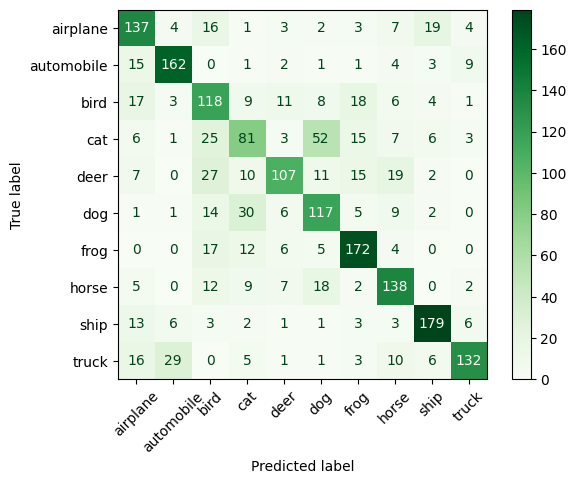

In [8]:
# Extract test data
X_test, y_test = next(iter(test_loader))

# Make predictions
y_pred = c_estimator.predict(X_test)

# Evaluate the classifier
print(classification_report(y_test, y_pred))

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES_LABELS)
disp.plot(cmap='Greens', xticks_rotation=45)
plt.show()

Having evaluated the classical estimator, we now venture into integrating a quantum component to form a quantum-classical hybrid neural network. Our initial step in this direction involves the definition of the quantum elements: the feature map and the variational form (ansatz). To simplify our approach, we will employ the [IQP embedding](https://arxiv.org/abs/1804.11326) mechanism alongside the widely recognized EfficientSU2 variational form with full entanglement pattern.

Leveraging these quantum components within FastQML enables us to construct a QNN Classifier with ease, mirroring the process of developing a classical machine learning model. Our QNN will consist of two layers, and will utilise data [reuploading mechanism](https://arxiv.org/abs/1907.02085). This seamless integration facilitates the exploration of hybrid models, combining the strengths of classical deep learning architectures with the novel capabilities of quantum computing to potentially enhance performance and uncover new insights.

In [22]:
# Create AngleEmbedding feature map
feature_map = IQPEmbedding(
    n_qubits=NUM_CLASSES
)

# EfficientSU2 ansatz
ansatz = EfficientSU2(
    n_qubits=NUM_CLASSES,
    entanglement='full',
    skip_last_rotations=False
)

# Create VQClassifier model with defined ansatz and feature map
q_model = QNNClassifier(
    n_qubits=NUM_CLASSES,
    feature_map=feature_map,
    ansatz=ansatz,
    loss_fn=optax.softmax_cross_entropy_with_integer_labels,
    optimizer_fn=optax.adamw,
    data_reuploading=True,
    layers_num=2,
    classes_num=NUM_CLASSES
)

In the hybrid model, we will continue to utilize DenseNet for the classical component. The core architecture of DenseNet will remain unchanged, instead, we will enhance it by integrating a quantum component that outputs the relevant probabilities. This approach ensures the original model's integrity while incorporating quantum capabilities to augment its performance.

In [23]:
c_model = DenseNet(
    num_outputs=NUM_CLASSES,
    num_layers=[3, 3, 3],
    bn_size=2,
    growth_rate=12,
    batch_norm=True
)

hybrid_estimator = HybridClassifier(
    input_shape=IMAGE_DIMS,
    c_model=c_model,
    q_model=q_model,
    batch_norm=True
)

With the hybrid model set up, we're now ready to proceed with training, applying the same parameters and data as used for the classical model.

In [24]:
hybrid_estimator.fit(
    train_data=train_loader,
    train_targets=None,
    val_data=val_loader,
    val_targets=None,
    learning_rate=H_LEARNING_RATE,
    num_epochs=NUM_EPOCHS
)

Epoch 1/75 - train_loss: 2.158577011 - val_loss: 2.340496279
Epoch 2/75 - train_loss: 2.062178986 - val_loss: 2.339645854
Epoch 3/75 - train_loss: 2.016754628 - val_loss: 2.291872247
Epoch 4/75 - train_loss: 1.974016257 - val_loss: 2.255899161
Epoch 5/75 - train_loss: 1.949377302 - val_loss: 2.293940807
Epoch 6/75 - train_loss: 1.923610853 - val_loss: 2.225524030
Epoch 7/75 - train_loss: 1.893467139 - val_loss: 2.186446461
Epoch 8/75 - train_loss: 1.874052560 - val_loss: 2.188061294
Epoch 9/75 - train_loss: 1.842044931 - val_loss: 2.138579188
Epoch 10/75 - train_loss: 1.827974885 - val_loss: 2.034298049
Epoch 11/75 - train_loss: 1.801947196 - val_loss: 2.091980486
Epoch 12/75 - train_loss: 1.789525733 - val_loss: 1.988199222
Epoch 13/75 - train_loss: 1.773432798 - val_loss: 1.968845056
Epoch 14/75 - train_loss: 1.757062968 - val_loss: 1.849223282
Epoch 15/75 - train_loss: 1.740573168 - val_loss: 1.933024061
Epoch 16/75 - train_loss: 1.709628155 - val_loss: 1.851118174
Epoch 17/75 - tra

              precision    recall  f1-score   support

           0       0.60      0.74      0.67       196
           1       0.83      0.89      0.86       198
           2       0.63      0.55      0.59       195
           3       0.61      0.40      0.48       199
           4       0.63      0.73      0.67       198
           5       0.69      0.61      0.65       185
           6       0.72      0.86      0.78       216
           7       0.71      0.74      0.72       193
           8       0.83      0.85      0.84       217
           9       0.89      0.75      0.82       203

    accuracy                           0.72      2000
   macro avg       0.71      0.71      0.71      2000
weighted avg       0.72      0.72      0.71      2000


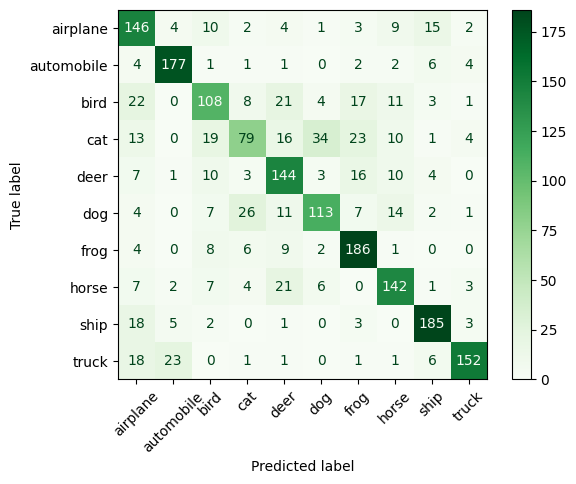

In [25]:
# Make predictions
y_pred = hybrid_estimator.predict(X_test)

# Evaluate the classifier
print(classification_report(y_test, y_pred))

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES_LABELS)
disp.plot(cmap='Greens', xticks_rotation=45)
plt.show()

In conclusion, the exploration of the quantum-classical hybrid model, as compared to its purely classical counterpart, yields insightful findings. By integrating a quantum component into the foundational DenseNet architecture, we have observed enhanced performance within the same number of epochs. This improvement underscores the potential benefits and efficiencies that a quantum-classical approach may offer. **Nevertheless, it is crucial to note that the primary objective of this notebook was not to optimize for the highest possible performance outcomes. Both the classical and quantum components of our models were designed to demonstrate the functionalities of FastQML and potential of hybrid quantum-classical computing rather than to be finely tuned for this specific task. For optimal results, each component would require careful optimization tailored to the task at hand, along with extensive training over a sufficient number of epochs using well-chosen hyperparameters.**